In [25]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import os
import numpy as np

In [26]:
file_location = "./test_8_2/"
filename = "3001.csv"
data = pd.read_csv(os.path.join(file_location,filename), converters={'Datetime': str.strip, 'Transaction ID': str.strip, 'Status': str.strip})

In [27]:
# Preview data
data.head()

,Datetime,Transaction ID,Status
0,04-18-2019 14:57:44.204409,0e0c79896159d0f2bb6196817eaff8f670adf3fd19867b...,REQ
1,04-18-2019 14:57:44.205374,0e0c79896159d0f2bb6196817eaff8f670adf3fd19867b...,IVS
2,04-18-2019 14:57:44.205865,0e0c79896159d0f2bb6196817eaff8f670adf3fd19867b...,REC_INIT
3,04-18-2019 14:57:44.206584,0e0c79896159d0f2bb6196817eaff8f670adf3fd19867b...,TRS
4,04-18-2019 14:57:44.206644,0e0c79896159d0f2bb6196817eaff8f670adf3fd19867b...,ACC


In [28]:
status = data["Status"].unique()
history = {}
for i in status:
    history[i] = {}
print(history)

{'REQ': {}, 'IVS': {}, 'REC_INIT': {}, 'TRS': {}, 'ACC': {}}


In [29]:
for key,rows in data.iterrows():
    history[rows["Status"]][rows["Transaction ID"]] = rows["Datetime"]    

In [30]:
for i in status:
    for key,value in history[i].items():
        try: # correct format 
            history[i][key] = datetime.utcnow().strptime(value, "%m-%d-%Y %H:%M:%S.%f")
        except ValueError: # Format in nanoseconds, truncate it
            history[i][key] = datetime.utcnow().strptime(value[:26], "%m-%d-%Y %H:%M:%S.%f")
        except TypeError:
            continue
    # requested[key] = datetime.utcnow().strptime(value[:-3], "%d-%m-%Y %H:%M:%S.%f")

In [31]:
def movingaverage(interval, window_size):
    cumsum_vec = np.cumsum(np.insert(interval, 0, 0)) 
    ma_vec = (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size
    return ma_vec

# Time taken for transaction to be Accepted

In [32]:
time_from_start = {}
for transactionID, time in history['ACC'].items():
    #print(transactionID)
    req_time = history['TRS'][transactionID]
    time_from_start[transactionID] = (time-req_time).total_seconds()*1000

In [33]:
list_time_from_start = list(time_from_start.values())[1:]

Mean:  0.045971590909090906  ms
Standard Deviation:  0.012233386198500517  ms
Number of accepted transactions:  528


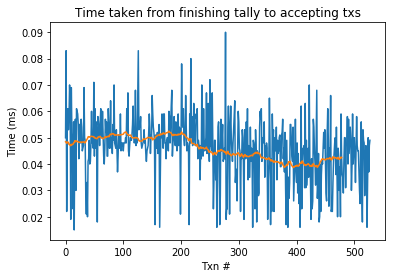

In [34]:
plt.title('Time taken from finishing tally to accepting txs')
plt.xlabel('Txn # ')
plt.ylabel('Time (ms)')
plt.plot(list_time_from_start)
x_av = movingaverage(list_time_from_start, 50)
plt.plot(x_av)
print("Mean: ",statistics.mean(list_time_from_start)," ms")
print("Standard Deviation: ",statistics.stdev(list_time_from_start)," ms")
print("Number of accepted transactions: ", len(list_time_from_start))
# plt.savefig(os.path.join(file_location,"res_acc_init.png"))

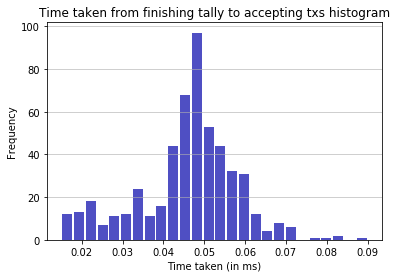

In [35]:
hist, bin_edges = np.histogram(list_time_from_start)
n, bins, patches = plt.hist(x=list_time_from_start, bins='auto', 
                            color='#0504aa', alpha=0.7, rwidth=0.85) # color-related params
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Time taken (in ms)')
plt.ylabel('Frequency')
plt.title('Time taken from finishing tally to accepting txs histogram')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [36]:
time_voting = {}
for transactionID, time in history['IVE'].items():
    #print(transactionID)
    req_time = history['IVS'][transactionID]
    time_voting[transactionID] = (time-req_time).total_seconds()*1000

KeyError: 'IVE'

Mean:  19.023447679708827  ms
Standard Deviation:  9.64162012919051  ms


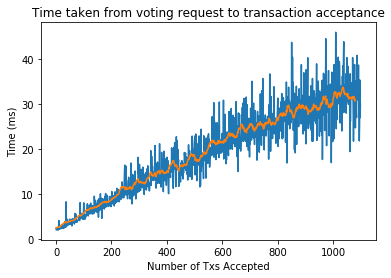

In [46]:
plt.title('Time taken from handle initvote to casting vote for txs')
plt.xlabel('Txn # ')
plt.ylabel('Time (ms)')
plt.plot(time_voting)
x_av = movingaverage(time_voting, 20)
plt.plot(x_av)
print("Mean: ",statistics.mean(time_voting)," ms")
print("Standard Deviation: ",statistics.stdev(time_voting)," ms")

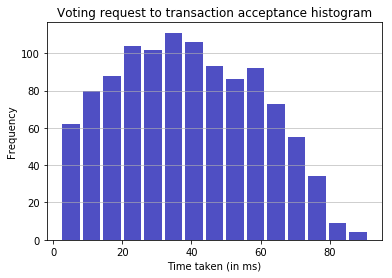

In [35]:
hist, bin_edges = np.histogram(list_time_from_req)
n, bins, patches = plt.hist(x=list_time_from_req, bins='auto', 
                            color='#0504aa', alpha=0.7, rwidth=0.85) # color-related params
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Time taken (in ms)')
plt.ylabel('Frequency')
plt.title('Voting request to transaction acceptance histogram')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

# Time taken for rejection of transaction due to previous transaction is not validated!

In [15]:
time_from_init = {}
time_from_req = {}
time_from_req_to_init = {}
for transactionID, time in history['REJ'].items():
    #print(transactionID)
    req_time = history['REQ'][transactionID]
    try:
        init_time = history['INIT'][transactionID]
    except KeyError:
        init_time = history['REC_INIT'][transactionID]
    time_from_init[transactionID] = (time-init_time).total_seconds()*1000
    time_from_req[transactionID] = (time-req_time).total_seconds()*1000
    time_from_req_to_init[transactionID] = (init_time-req_time).total_seconds()*1000

In [16]:
list_time_from_init = list(time_from_init.values())[1:]
list_time_from_req = list(time_from_req.values())[1:]

Mean:  524.8239889638259  ms
Standard Deviation:  31.992438796431827  ms
Number of rejected txs:  1632


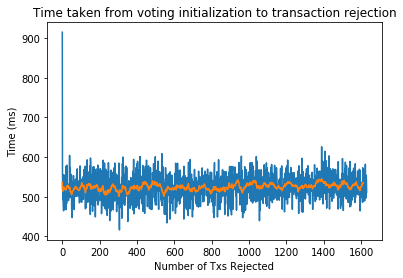

In [17]:
plt.title('Time taken from voting initialization to transaction rejection')
plt.xlabel('Number of Txs Rejected')
plt.ylabel('Time (ms)')
plt.plot(list_time_from_init)
x_av = movingaverage(list_time_from_init, 20)
plt.plot(x_av)
print("Mean: ",statistics.mean(list_time_from_init)," ms")
print("Standard Deviation: ",statistics.stdev(list_time_from_init)," ms")
print("Number of rejected txs: ", len(time_from_init))
plt.savefig(os.path.join(file_location,"res_rej.png"))